Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 47.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

--- Training ResNet-10 ---
Epoch [10/200], Loss: 0.1702
Epoch [20/200], Loss: 0.0546
Epoch [30/200], Loss: 0.0351
Epoch [40/200], Loss: 0.0241
Epoch [50/200], Loss: 0.0202
Epoch [60/200], Loss: 0.0181
Epoch [70/200], Loss: 0.0143
Epoch [80/200], Loss: 0.0127
Epoch [90/200], Loss: 0.0086
Epoch [100/200], Loss: 0.0132
Epoch [110/200], Loss: 0.0092
Epoch [120/200], Loss: 0.0093
Epoch [130/200], Loss: 0.0090
Epoch [140/200], Loss: 0.0084
Epoch [150/200], Loss: 0.0050
Epoch [160/200], Loss: 0.0066
Epoch [170/200], Loss: 0.0052
Epoch [180/200], Loss: 0.0062
Epoch [190/200], Loss: 0.0079
Epoch [200/200], Loss: 0.0066
Total Training Time: 69.02 minutes

Training Accuracy: 99.93%
Test Accuracy: 81.17%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.82      0.85      0.83      1000
  automobile       0.87      0.93      0.90      1000
        bird       0.

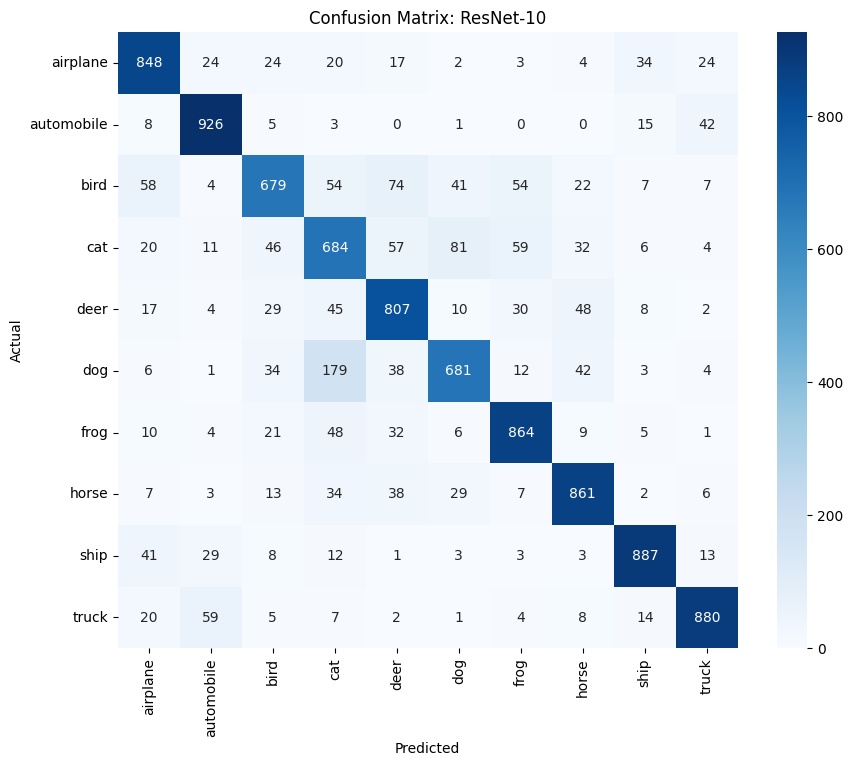

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define CIFAR-10 Dataset Preparation
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

# Define ResNet-10
class ResNet10(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet10, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.layer4 = self._make_layer(128, 2, stride=2)
        self.linear = nn.Linear(128, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.mean(out, dim=(2, 3))  # Global Average Pooling
        out = self.linear(out)
        return out

# Initialize model, optimizer, and loss function
model = ResNet10(num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training function
def train_model(model, train_loader, optimizer, loss_fn, epochs=200):
    model.train()
    start_time = time.time()  # Start the timer
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")
    end_time = time.time()  # End the timer
    total_time = end_time - start_time
    print(f"Total Training Time: {total_time / 60:.2f} minutes")

# Evaluate function
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return accuracy, true_labels, predictions

# Train the model
print("\n--- Training ResNet-10 ---")
train_model(model, train_loader, optimizer, loss_fn, epochs=200)

# Evaluate the model
train_accuracy, _, _ = evaluate_model(model, train_loader)
test_accuracy, true_labels, predictions = evaluate_model(model, test_loader)

print(f"\nTraining Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate Classification Report
print("\nClassification Report:")
class_names = train_dataset.classes
print(classification_report(true_labels, predictions, target_names=class_names))

# Plot Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: ResNet-10")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
